# Build cleaned dataset and generate paraphrases

## install and import librarys

In [ ]:
%pip install unidecode
%pip install matplotlib
%pip install tqdm
%pip install tiktoken
%pip install anthropic

In [1]:
from tqdm import tqdm
import pandas as pd
import re
from unidecode import unidecode
import tiktoken
import os
import time
import asyncio
from openai import OpenAI
from tqdm.asyncio import tqdm_asyncio
import json
from itertools import permutations 
import random
import numpy as np
import anthropic
from anthropic.types.message_create_params import MessageCreateParamsNonStreaming
from anthropic.types.messages.batch_create_params import Request

In [3]:
df  = pd.read_json('150token-chunks-1500chars.json') # dataset provided to us by O'Reilly Media
df

,identifier,date_published,title,status,author,chapter_number,snippet
0,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,# Chapter 1\. Continuously Learn to Protect T...
1,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,I’ve personally found that I’ve developed new ...
2,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,on these technical responsibilities to diverse...
3,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,to learn is the intuition for what questions t...
4,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch02,# Chapter 2\. Fight in Cyber like the Militar...
...,...,...,...,...,...,...,...
25879,9781492098041,2022-11-10,Applied Machine Learning and AI for Engineers,private,"Prosise, Jeff",ch14,translated_lines = [] for result...
25880,9781492098041,2022-11-10,Applied Machine Learning and AI for Engineers,private,"Prosise, Jeff",ch14,"image,” add the following line of code to call..."
25881,9781492098041,2022-11-10,Applied Machine Learning and AI for Engineers,private,"Prosise, Jeff",ch14,changes to *app.py*. Return to the browser in ...
25882,9781492098041,2022-11-10,Applied Machine Learning and AI for Engineers,private,"Prosise, Jeff",ch14,Azure Cognitive Services lower the bar for inc...


In [4]:
chapters = []

for book_name, book_df in df.groupby('title'):
    author = book_df['author'].iloc[0]
    identifier = book_df['identifier'].iloc[0]
    date_published = book_df['date_published'].iloc[0]
    title = book_df['title'].iloc[0]
    for chapter_name, chapter_df in book_df.groupby('chapter_number'):
        public_text = ' '.join(chapter_df[chapter_df['status'] == 'public'].snippet).replace("  ", "\n")
        private_text = ' '.join(chapter_df[chapter_df['status'] == 'private'].snippet).replace("  ", "\n")
        chapters.append({
            'book_name': book_name,
            'chapter_name': chapter_name,
            'author': author,
            'identifier': identifier,
            'date_published': date_published,
            'title': title,
            'public_text': public_text,
            'private_text': private_text
        })

books = pd.DataFrame(chapters)
books.to_csv('books.csv', index=False)

In [5]:
def remove_bold_italics_links(text):
    """
    Remove bold, italics, inline links, and inline code from Markdown text, keeping other text unchanged.

    Args:
        text (str): The input text containing Markdown.

    Returns:
        str: The text with bold, italics, inline links, and inline code removed.
    """
    # Remove images
    text = re.sub(r'\!\[.*?\]\(.*?\)', '', text)
    # Remove bold (**text**)
    text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
    # Remove italics (*text* or _text_)
    text = re.sub(r'\*(.*?)\*', r'\1', text)
    text = re.sub(r'_(.*?)_', r'\1', text)
    # Remove inline links [text](url)
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
  
    # Remove inline code (`code`)
    # text = re.sub(r'`(.*?)`', r'\1', text)
    return text

def clean_text(text):
    """
    Cleans a string by removing URLs and punctuation.

    Parameters:
    text (str): The input string to be cleaned.

    Returns:
    str: The cleaned string.
    """
    text = remove_bold_italics_links(text)

    # get rid of code blocks and return text
    text = re.sub(r'```.*?```', '\n', text, flags=re.DOTALL)
    lines = []
    for line in text.splitlines():
        line = line.strip()
        # remove headings
        if line.startswith('#'):
            line = ':('
        # remove lists
        if line.startswith('-') or line.startswith('*'):
            line = ':('
        # remove blockquotes
        if line.startswith('>'):
            line = ':('
        # remove tables
        if line.startswith('|'):
            line = ':('
        # remove horizontal rules
        if line.startswith('---'):
            line = ':('
        # remove lines that begin with 'table \d'
        if re.match(r'table \d', line, re.IGNORECASE):
            line = ':('
        # remove lines that don't end with punctuation
        if not re.match(r'.*[.!?]$', line):
            line = ':('
        # remove lines that start with a number
        if re.match(r'^\d+', line):
            line = ':('
        lines.append(line)

    text = '\n\n'.join(lines)

    return text


In [ ]:
def split_text(text, min_words):
    """
    Splits a given text into chunks, ensuring splits occur at sentence boundaries and that each chunk has at least a minimum number of words.

    Args:
        text (str): The text to split.
        min_words (int): The minimum number of words per chunk.

    Returns:
        list: A list of paragraphs or sentence chunks.
    """

    # Split text into paragraphs
    paragraphs = text.split("\n\n")

    # Helper function to split paragraphs into chunks with a minimum word count at sentence boundaries
    def split_paragraph(paragraph, min_words):
        sentences = re.split(r'(?<=[.!?])\s+', paragraph)
        chunks = []
        current_chunk = []
        current_word_count = 0

        for sentence in sentences:
            word_count = len(sentence.split())
            # If adding this sentence would exceed the minimum word count add it and create a new chunk
            if current_word_count + word_count >= min_words:
                current_chunk.append(sentence)
                chunks.append(" ".join(current_chunk))
                current_chunk = []  # Start a new chunk
                current_word_count = 0
            else:
                # Otherwise, just add the sentence to the current chunk
                current_chunk.append(sentence)
                current_word_count += word_count

        # Add any remaining sentences as a chunk if it meets the minimum word count
        if current_chunk:
            if len(" ".join(current_chunk).split()) >= min_words:
                chunks.append(" ".join(current_chunk))
            elif chunks:
                # If not, merge it with the last chunk
                chunks[-1] += " " + " ".join(current_chunk)
            else:
                # If no previous chunk exists, create a single chunk
                chunks.append(" ".join(current_chunk))

        return chunks

    result = []
    for paragraph in paragraphs:
        if len(paragraph.split()) >= min_words:
            result.extend(split_paragraph(paragraph, min_words))

    return result


In [ ]:
def word_count(text):
    """
    Counts the number of words in a given text.

    Args:
        text (str): The text to count the words in.

    Returns:
        int: The number of words in the text.
    """
    return len(text.split())

def split_text_and_combine_paragraphs(text, min_words=10):
    """
    Splits a given text into chunks, ensuring splits occur at sentence boundaries and that each chunk has at least a minimum number of words.

    Args:
        text (str): The text to split.
        min_words (int): The minimum number of words per chunk.

    Returns:
        list: A list of paragraphs or sentence chunks.
    """

    # Split text into paragraphs
    paragraphs = text.split("\n\n")

    # Helper function to split paragraphs into chunks with a minimum word count at sentence boundaries
    def split_paragraph(paragraph, min_words):
        sentences = re.split(r'(?<=[.!?])\s+', paragraph)
        chunks = []
        current_chunk = []
        current_word_count = 0

        for sentence in sentences:
            word_count = len(sentence.split())
            if current_word_count + word_count >= min_words:
                current_chunk.append(sentence)
                chunks.append(" ".join(current_chunk))
                current_chunk = []  # Start a new chunk
                current_word_count = 0
            else:
                current_chunk.append(sentence)
                current_word_count += word_count

        # Add any remaining sentences as a chunk if it meets the minimum word count
        if current_chunk:
            if len(" ".join(current_chunk).split()) >= min_words:
                chunks.append(" ".join(current_chunk))
            elif chunks:
                # If not, merge it with the last chunk
                chunks[-1] += " " + " ".join(current_chunk)
            else:
                # If no previous chunk exists, create a single chunk
                chunks.append(" ".join(current_chunk))

        return chunks
    combined_paragraphs = []
    cursor = ''

    for paragraph in paragraphs:
        # since we use :( as as a separator around which paragraphs can not be combined, we need to clear our cursor
        if paragraph == ':(':
            cursor = ''
        elif word_count(paragraph) >= min_words:
            combined_paragraphs.append(paragraph)
            cursor = ''
        elif word_count(cursor + paragraph) >= min_words:
            combined_paragraphs.append(cursor + ' ' + paragraph)
            cursor = ''
        else:
            cursor += ' ' + paragraph
        



    result = []
    for paragraph in combined_paragraphs:
        if len(paragraph.split()) >= min_words:
            result.extend(split_paragraph(paragraph.strip(), min_words))

    return result

In [9]:
public_snippets = []
private_snippets = []
min_length = 85
for idx ,chapter in books.iterrows():
    public_text = clean_text(chapter.public_text)
    private_text = clean_text(chapter.private_text)
    for snippet in split_text_and_combine_paragraphs(public_text,min_length):
        public_snippets.append({
            "identifier": chapter.identifier,
            "date_published": chapter.date_published,
            "title": chapter.title,
            "status": 'public',
            "author": chapter.author,
            "chapter_name": chapter.chapter_name,
            "snippet": snippet

        })
    for snippet in split_text_and_combine_paragraphs(private_text,min_length):
        private_snippets.append({
            "identifier": chapter.identifier,
            "date_published": chapter.date_published,
            "title": chapter.title,
            "status": 'private',
            "author": chapter.author,
            "chapter_name": chapter.chapter_name,
            "snippet": snippet
        })

print(len(public_snippets), len(private_snippets))
    

pb = pd.DataFrame(private_snippets)
for book_name, book_df in pb.groupby('title'):
    print(book_name, len(book_df))
    

2539 11632
97 Things Every Information Security Professional Should Know 214
AI-Powered Business Intelligence 322
Advancing into Analytics 105
Applied Machine Learning and AI for Engineers 288
Azure Cookbook 23
Building Green Software 330
Building Knowledge Graphs 275
Building Recommendation Systems in Python and JAX 373
Building Solutions with the Microsoft Power Platform 223
C# 8.0 in a Nutshell 292
Cloud Native Go 307
Communicating with Data 377
Continuous Deployment 444
Data Quality Fundamentals 365
Deciphering Data Architectures 407
Delta Lake: Up and Running 153
DevOps Tools for Java Developers 384
Distributed Tracing in Practice 465
FastAPI 76
Genomics in the Cloud 682
Leading Lean 347
Learning Digital Identity 770
Natural Language Processing with Spark NLP 232
Policy as Code 241
Practical Natural Language Processing 450
Programming C# 10 1419
Prompt Engineering for Generative AI 223
RESTful Web API Patterns and Practices Cookbook 365
Scaling Machine Learning with Spark 264
Secu

In [ ]:
def get_rid_of_weird_character_sequences(snippet):
    return snippet.replace(r'\#', '#').replace(r'\-','-' ).replace(r'\.','.')

def not_contains_bib(snippet):
    pattern = r'\\\[?\w+\]'
    return not bool(re.search(pattern, snippet))


snippets_df = pd.concat([pd.DataFrame(public_snippets), pd.DataFrame(private_snippets)])
# clean weird artifacts in the text
snippets_df['snippet'] = snippets_df['snippet'].apply(get_rid_of_weird_character_sequences)
# remove snippets that contain bibtex references
snippets_df = snippets_df[snippets_df['snippet'].apply(not_contains_bib)]


snippets_df = snippets_df.reset_index(drop=True)

snippets_df.to_csv('oreilly_snippets.csv')

In [43]:
snippets_df.title.value_counts().describe()

count      34.000000
mean      410.647059
std       259.893554
min        46.000000
25%       306.750000
50%       381.500000
75%       450.750000
max      1538.000000
Name: count, dtype: float64

In [44]:
snippets_df.snippet.apply(word_count).describe()

count    13962.000000
mean       112.494557
std         21.752994
min         85.000000
25%         95.000000
50%        108.000000
75%        125.000000
max        222.000000
Name: snippet, dtype: float64

In [221]:
snippets_df.iloc[224].snippet

'In Chapter\xa01 you learned how to conduct exploratory data analysis in Excel. You may recall from that chapter that John Tukey is credited with popularizing the practice of EDA. Tukey’s approach to data inspired the development of several statistical programming languages, including S at the legendary Bell Laboratories. In turn, S inspired R. Developed in the early 1990s by Ross Ihaka and Robert Gentleman, the name is a play both on its derivation from S and its cofounders’ first names. R is open source and maintained by the R Foundation for Statistical Computing. Because it was built primarily for statistical computation and graphics, it’s most popular among researchers, statisticians, and data scientists.'

In [ ]:
# print out snippet counts per book
pb = pd.DataFrame(private_snippets)
for book_name, book_df in pb.groupby('title'):
    print(book_name, len(book_df))
    # if book_name== 'FastAPI':
        # print(book_df.chapter_name,'len',len(book_df.snippet.iloc[0]))

97 Things Every Information Security Professional Should Know 214
AI-Powered Business Intelligence 322
Advancing into Analytics 105
Applied Machine Learning and AI for Engineers 288
Azure Cookbook 23
Building Green Software 330
Building Knowledge Graphs 275
Building Recommendation Systems in Python and JAX 373
Building Solutions with the Microsoft Power Platform 223
C# 8.0 in a Nutshell 292
Cloud Native Go 307
Communicating with Data 377
Continuous Deployment 444
Data Quality Fundamentals 365
Deciphering Data Architectures 407
Delta Lake: Up and Running 153
DevOps Tools for Java Developers 384
Distributed Tracing in Practice 465
FastAPI 76
Genomics in the Cloud 682
Leading Lean 347
Learning Digital Identity 770
Natural Language Processing with Spark NLP 232
Policy as Code 241
Practical Natural Language Processing 450
Programming C# 10 1419
Prompt Engineering for Generative AI 223
RESTful Web API Patterns and Practices Cookbook 365
Scaling Machine Learning with Spark 264
Security and Mi

In [ ]:
# show an example of a snippet being split
text = books.iloc[0]['public_text'].strip()
text = clean_text(text)

chunks = split_text(text,100)
chunks


['Learn with a community. I’ve personally found that I’ve developed new and existing skills much faster (by a magnitude of months) when I’ve joined a community of learners than when I was trying to learn the same skills alone. By attending local and online user groups, conferences, and other events, you can discover new concepts, hone new skills, and network with possible future colleagues. Also, in a community, you will gain a more holistic perspective of information security and a more complete picture of how others are managing successful information security programs. Learn the fundamentals of effective communication. Although an emphasis is often placed on learning the technical skills necessary to succeed in information security, you also need to bring a similar level of intensity to improving your communication skills.',
 'Understanding how to secure a network or be in compliance with a privacy regulation is just as important as understanding how to communicate reports on these 

In [81]:
len(chunks[2].split(" "))

150

In [262]:
seed = 42
random.seed(seed)
np.random.seed(seed)
random.randint(0, 100)

81

# Generate paraphrases

In [ ]:
client = anthropic.Anthropic(api_key="<API_KEY>")

generate_prompt = """
Rewrite this entire text (all sentences with no exception) expressing the same meaning using different words. Aim to keep the rewriting similar in length to the original text. Do it three times. The text to be rewritten is identified as <Example A>.
Format your output as:
Example B: <insert paraphrase B>
Example C: <insert paraphrase C>
Example D: <insert paraphrase D>
-
Example A: {ref_text}""".strip()

def generate_alternatives(snippet,custom_id,model="claude-3-5-sonnet-20241022"):
    """Generates 3 alternatives for a given snippet"""
    print(custom_id)
    prompt = generate_prompt.format(ref_text=snippet)
    return Request(
        custom_id=str(custom_id),
        params=MessageCreateParamsNonStreaming(
                model=model,
                max_tokens=2048,
                temperature=0.1,
                messages=[
                    {"role": "user", "content": prompt},
                ],
            )
    )

In [47]:
Request(
            custom_id="my-first-request",
            params=MessageCreateParamsNonStreaming(
                model="claude-3-5-sonnet-20241022",
                max_tokens=1024,
                messages=[{
                    "role": "user",
                    "content": "Hello, world",
                }]
            )
        )


{'custom_id': 'my-first-request',
 'params': {'model': 'claude-3-5-sonnet-20241022',
  'max_tokens': 1024,
  'messages': [{'role': 'user', 'content': 'Hello, world'}]}}

In [20]:
# sample message
generate_alternatives("Information security is a shared responsibility among every member of an organization, so the real impact of an information security professional’s work depends on how well other people can understand their reports and make informed decisions to improve their security program. Learn concepts hands-on, as it’s the best way to grow and progress your information security skills. Participating in a CTF (capture the flag) or completing a basic project (e. WiFi router) for a relative or friend and writing about your experience is often much better than only reading through abstract concepts in textbooks or certification exam study guides. Your experience using real-world tools is just as necessary as your experience studying for academic credentials and certifications, as it translates theoretical ideas into practical outcomes. Learn how to ask the right questions.",'bobn')

{'custom_id': 'bobn',
 'params': {'model': 'claude-3-5-sonnet-20241022',
  'max_tokens': 2048,
  'temperature': 0.1,
  'messages': [{'role': 'user',
    'content': 'Rewrite this entire text (all sentences with no exception) expressing the same meaning using different words. Aim to keep the rewriting similar in length to the original text. Do it three times. The text to be rewritten is identified as <Example A>.\nFormat your output as:\nExample B: <insert paraphrase B>\nExample C: <insert paraphrase C>\nExample D: <insert paraphrase D>\n-\nExample A: Information security is a shared responsibility among every member of an organization, so the real impact of an information security professional’s work depends on how well other people can understand their reports and make informed decisions to improve their security program. Learn concepts hands-on, as it’s the best way to grow and progress your information security skills. Participating in a CTF (capture the flag) or completing a basic p

In [ ]:
requests=[]

for idx, row in enumerate(snippets_df.itertuples(index=False)):
    requests.append(generate_alternatives(row.snippet,idx))

list_to_jsonl(requests,'./batch_paraphrase.jsonl')

In [58]:
import json

def list_to_jsonl(list_of_dicts, output_file):
    """
    Converts a list of dictionaries to a JSONL file.

    Args:
        list_of_dicts (list): List of dictionaries to write to a JSONL file.
        output_file (str): Path to the output JSONL file.

    Returns:
        None
    """
    with open(output_file, 'w', encoding='utf-8') as file:
        for item in list_of_dicts:
            file.write(json.dumps(item) + '\n')

def jsonl_to_list(jsonl_file):
    """
    Converts a JSONL file to a list of dictionaries.

    Args:
        jsonl_file (str): Path to the input JSONL file.

    Returns:
        list: List of dictionaries read from the JSONL file.
    """
    list_of_dicts = []
    with open(jsonl_file, 'r', encoding='utf-8') as file:
        for line in file:
            list_of_dicts.append(json.loads(line.strip()))
    return list_of_dicts

In [54]:
len(requests)

13962

In [328]:
jsonl_to_list('./batch_paraphrase.jsonl')

[{'custom_id': '0',
  'params': {'model': 'claude-3-5-sonnet-20241022',
   'max_tokens': 2048,
   'temperature': 0.1,
   'messages': [{'role': 'user',
     'content': 'Rewrite this entire text (all sentences with no exception) expressing the same meaning using different words. Aim to keep the rewriting similar in length to the original text. Do it three times. The text to be rewritten is identified as <Example A>.\nFormat your output as:\nExample B: <insert paraphrase B>\nExample C: <insert paraphrase C>\nExample D: <insert paraphrase D>\n-\nExample A: Learn with a community. I’ve personally found that I’ve developed new and existing skills much faster (by a magnitude of months) when I’ve joined a community of learners than when I was trying to learn the same skills alone. By attending local and online user groups, conferences, and other events, you can discover new concepts, hone new skills, and network with possible future colleagues. Also, in a community, you will gain a more holist

In [59]:
requests = jsonl_to_list('./batch_paraphrase.jsonl')

message_batch = client.messages.batches.create(
    requests=requests,
)

## Build dataset after paraphrasing

In [2]:
df_batches = pd.read_json('./msgbatch_01VoApvYumUq9Eyc8zx5ugEM_results.jsonl', lines=True)
df = pd.read_csv('oreilly_snippets.csv', index_col=0)
df['Snippet_ID'] = df.index
merged_df = pd.merge(df, df_batches, left_index=True, right_on='custom_id', how='inner')
merged_df

,identifier,date_published,title,status,author,chapter_name,snippet,Snippet_ID,custom_id,result
0,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,Learn with a community. I’ve personally found ...,0,0,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
1,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,Learn the fundamentals of effective communicat...,1,1,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
2,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,"Learn concepts hands-on, as it’s the best way ...",2,2,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
3,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,"Learn how to ask the right questions. By far, ...",3,3,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
4,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch02,"To summarize the concept, the goal is to prope...",4,4,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
...,...,...,...,...,...,...,...,...,...,...
13957,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,Operating systems provide users with more and ...,13957,13957,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
13958,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,"In Recipe 5.2, you’ve learned that respecting ...",13958,13958,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
13959,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,"Polypane, the browser for web developers, offe...",13959,13959,"{'type': 'succeeded', 'message': {'id': 'msg_0..."
13960,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,Another exciting way of testing accessibility ...,13960,13960,"{'type': 'succeeded', 'message': {'id': 'msg_0..."


In [3]:


def extract_examples(text):
    # Define the pattern to match examples and only capture the content after "Example X:"
    pattern = r"Example [A-Z]:\s*(.*?)(?=\n\n|$)"  # Capture everything after "Example X:" until a double newline or end of text

    # Use re.findall to extract all matching examples
    matches = re.findall(pattern, text, re.DOTALL)

    # Return the extracted examples
    return matches

result = merged_df.iloc[0].result['message']['content'][0]['text']
result


extract_examples(result)

['Connect with fellow learners. From my experience, acquiring and improving abilities has been significantly quicker (saving several months) when participating in group learning compared to solo studying. Going to regional and virtual meetups, seminars, and similar gatherings helps you explore fresh ideas, develop capabilities, and build relationships with potential workmates. Furthermore, learning within a group provides broader insights into cybersecurity and better understanding of how various organizations implement effective security initiatives.',
 "Join a learning group. Based on my observations, mastering both new and current abilities happens much more rapidly (reducing learning time by months) when I'm part of a learning circle versus studying independently. Through participation in area-based and internet-hosted gatherings, symposiums, and other meetings, you'll encounter different concepts, sharpen your abilities, and connect with prospective professional contacts. Addition

In [4]:
for idx, row in merged_df.iterrows():    
    result = row.result['message']['content'][0]['text']
    example_a = row.snippet
    example_b,example_c,example_d =  extract_examples(result)
    merged_df.at[idx, 'Example_A'] = example_a
    merged_df.at[idx, 'Example_B'] = example_b
    merged_df.at[idx, 'Example_C'] = example_c
    merged_df.at[idx, 'Example_D'] = example_d
    merged_df.at[idx, 'Answer'] = 'A'

merged_df


,identifier,date_published,title,status,author,chapter_name,snippet,Snippet_ID,custom_id,result,Example_A,Example_B,Example_C,Example_D,Answer
0,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,Learn with a community. I’ve personally found ...,0,0,"{'type': 'succeeded', 'message': {'id': 'msg_0...",Learn with a community. I’ve personally found ...,Connect with fellow learners. From my experien...,Join a learning group. Based on my observation...,Engage in collaborative learning. My personal ...,A
1,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,Learn the fundamentals of effective communicat...,1,1,"{'type': 'succeeded', 'message': {'id': 'msg_0...",Learn the fundamentals of effective communicat...,Master the basics of clear communication pract...,Grasp the essential principles of successful m...,Acquire the core elements of proper informatio...,A
2,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,"Learn concepts hands-on, as it’s the best way ...",2,2,"{'type': 'succeeded', 'message': {'id': 'msg_0...","Learn concepts hands-on, as it’s the best way ...",Develop your cybersecurity abilities through p...,Master security concepts through direct practi...,Acquire cybersecurity knowledge through active...,A
3,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch01,"Learn how to ask the right questions. By far, ...",3,3,"{'type': 'succeeded', 'message': {'id': 'msg_0...","Learn how to ask the right questions. By far, ...",Master the art of effective inquiry. The most ...,Develop expertise in strategic questioning. No...,Perfect your ability to formulate key inquirie...,A
4,9781098101381,2021-09-14,97 Things Every Information Security Professio...,public,"Morillo, Christina",ch02,"To summarize the concept, the goal is to prope...",4,4,"{'type': 'succeeded', 'message': {'id': 'msg_0...","To summarize the concept, the goal is to prope...","In essence, the primary objective is to effici...",The key principle involves analyzing informati...,The main concept revolves around processing da...,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13957,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,Operating systems provide users with more and ...,13957,13957,"{'type': 'succeeded', 'message': {'id': 'msg_0...",Operating systems provide users with more and ...,Modern OS platforms offer increasing customiza...,Software platforms now include numerous custom...,Computer operating systems increasingly allow ...,A
13958,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,"In Recipe 5.2, you’ve learned that respecting ...",13958,13958,"{'type': 'succeeded', 'message': {'id': 'msg_0...","In Recipe 5.2, you’ve learned that respecting ...","As covered in Recipe 5.2, creating accessible ...",Recipe 5.2 demonstrated that accommodating use...,The importance of honoring user preferences in...,A
13959,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,"Polypane, the browser for web developers, offe...",13959,13959,"{'type': 'succeeded', 'message': {'id': 'msg_0...","Polypane, the browser for web developers, offe...",The developer-focused browser Polypane leads t...,"For web developers, Polypane browser provides ...","Among browsers designed for developers, Polypa...",A
13960,9781098145590,2024-06-17,Web Accessibility Cookbook,private,"Matuzovic, Manuel",ch13,Another exciting way of testing accessibility ...,13960,13960,"{'type': 'succeeded', 'message': {'id': 'msg_0...",Another exciting way of testing accessibility ...,An alternative engaging method for checking ac...,A fascinating approach to accessibility testin...,One innovative technique for accessibility val...,A


In [5]:
# Function to generate permutations of answer options and snippets
def generate_permutations(document_df):
    results = []  # List to store permutation results

    # Iterate over each row in the DataFrame
    for _, row in document_df.iterrows():
        # Mappings to convert between number and letter representations of answers
        num_to_letter_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        letter_to_num_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

        # Initialize the answer list with zeros and set the correct answer to 1
        answers = [0, 0, 0, 0]
        answers[letter_to_num_mapping[row['Answer']]] = 1

        # Generate all possible permutations of the answers and snippets
        answer_permutations = list(permutations(answers))

        # note: this leads to 24 permutations the series objects are treated as one object and they are rearanged in 24 diferent ways
        snippet_permutations = list(permutations([
            row['Example_A'], row['Example_B'], row['Example_C'], row['Example_D']
        ]))

        # Combine answer and snippet permutations
        for i, (answer_list, snippet_list) in enumerate(zip(answer_permutations, snippet_permutations)):
            # Find the index of the correct answer (marked as 1)
            index = answer_list.index(1)
            snippet = snippet_list[index]

            # Append a dictionary of the current permutation to the results
            results.append({
                **row.to_dict(),
                'Example_A': snippet_list[0],
                'Example_B': snippet_list[1],
                'Example_C': snippet_list[2],
                'Example_D': snippet_list[3],
                'Answer': num_to_letter_mapping[index],
                'Permutation_Number': i + 1
            })

    # Return the results as a new DataFrame
    return pd.DataFrame(results)

# Generate the permutations and update the DataFrame
huge_df = generate_permutations(merged_df)

In [6]:
huge_df.Permutation_Number.value_counts()

Permutation_Number
1     13962
2     13962
23    13962
22    13962
21    13962
20    13962
19    13962
18    13962
17    13962
16    13962
15    13962
14    13962
13    13962
12    13962
11    13962
10    13962
9     13962
8     13962
7     13962
6     13962
5     13962
4     13962
3     13962
24    13962
Name: count, dtype: int64

In [7]:
huge_df['Answer'].value_counts()

Answer
A    83772
B    83772
C    83772
D    83772
Name: count, dtype: int64

In [10]:
huge_df.rename(columns={'title': 'Title','status':'Status','author':'Author','snippet_id':'Snippet_ID'}, inplace=True)

In [11]:
def format_author(author):
    last_name, first_name = author.split(", ")
    return f"{first_name} {last_name}"

huge_df['Formatted Author'] = huge_df['Author'].apply(format_author)


<Axes: xlabel='Formatted Author'>

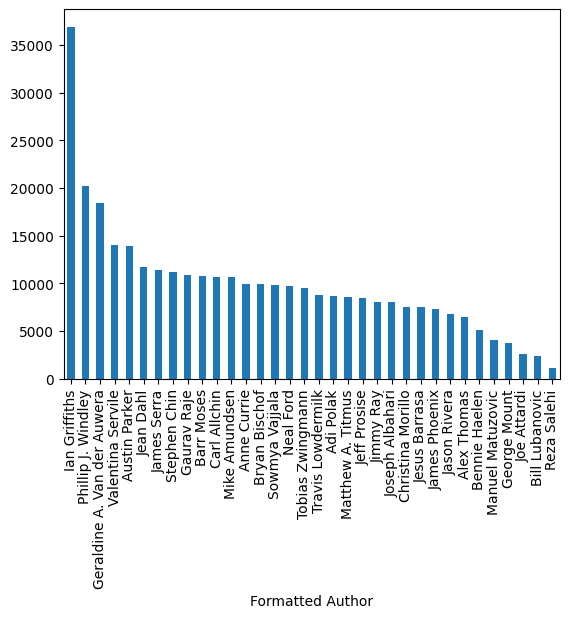

In [12]:
huge_df['Formatted Author'].value_counts().plot(kind='bar')

In [ ]:
huge_df.to_csv('./huge_df.csv', index=False)